6.8

In this exercise, we will generate simulated data, and will then use this data to perform forward and backward stepwise selection.

(a)

Create a random number generator and use its normal() method to generate a predictor $X$ of length $n = 100$, as well as a noise vector of length $n = 100$.

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
    (Stepwise,
     sklearn_selected,
     sklearn_selection_path)
import warnings; warnings.simplefilter('ignore')

rng = np.random.default_rng(42)
X = rng.normal(size=100)
eps = rng.normal(size=100)

(b)

Generate a response vector $Y$ of length $n = 100$ according to the model

$$
Y = \beta_{0} + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 \epsilon,
$$

Where $\beta_{0}, \beta_1, \beta_2,$ and $\beta_3$ are constraints of your choice.

In [2]:
Y = 3*np.ones(100) - 2.4*X + 0.42*X**2 - X**3 + eps

Y.shape

(100,)

(c)

Use forward stepwise selection in order to select a model containing the predictors $X,X^2,...,X^{10}$. What is the model obtained according to $C_p$? Report the coefficients of the model obtained.

In [3]:
def nCp(sigma2, estimator, X, Y):
    #Negative Cp statistic
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y-Yhat)**2)
    return -(RSS + 2 * p * sigma2)/n

In [4]:
Xs = pd.DataFrame({'X':X,'X2':X**2,'X3':X**3,'X4':X**4,'X5':X**5,'X6':X**6,'X7':X**7,'X8':X**8,'X9':X**9,'X10':X**10})
design = MS(Xs.columns).fit(Xs)
XX = design.transform(Xs)
sigma2 = OLS(Y,XX).fit().scale

neg_Cp = partial(nCp,sigma2)

In [5]:
stragety = Stepwise.first_peak(design,direction='forward',max_terms=len(design.terms))

data_Cp = sklearn_selected(OLS,stragety,scoring=neg_Cp)
data_Cp.fit(XX,Y)
data_Cp.selected_state_

('X', 'X2', 'X3')

(d)

Repeat (c), using backwards stepwise selection. How does your answer compare to the results in (c)?

In [6]:
aa = Stepwise.first_peak(design,direction='backwards', max_terms=len(design.terms))

data_Cp1 = sklearn_selected(OLS,aa,scoring=neg_Cp)
data_Cp1.fit(XX,Y)
data_Cp1.selected_state_

('X', 'X2', 'X3')

I get the same terms in both forward and backward stepwise selection method

(e)

Now fit a lasso model to the simulated data, again using $X,X^2,...,X^{10}$ as predictors. Use cross-validation to select the optimal value of $\lambda$. Create plots of the cross-validation error as a function of $\lambda$. Report the resulting coefficient estimates, and discuss the results obtained.

In [7]:
XXX = XX.drop('intercept',axis=1)
XXs = StandardScaler().fit_transform(XX,Y)

In [8]:
lambdas = 10**np.linspace(5,-10,200)/Y.std()

soln_array = skl.ElasticNet.path(XXs,Y,l1_ratio=1,alphas=lambdas)[1]
soln_array.shape

(11, 200)

In [9]:
soln_path = pd.DataFrame(soln_array.T, columns=XX.columns,index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'

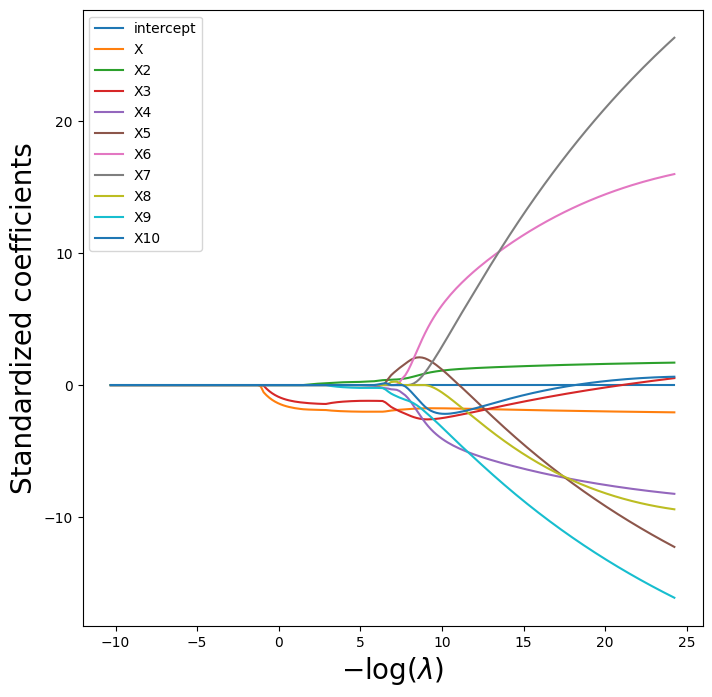

In [10]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$',fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left')

In [11]:
lambdas = 10**np.linspace(1,-1,100)/Y.std()
lasso = skl.ElasticNet(alpha=lambdas[30],l1_ratio=1)
scaler = StandardScaler(with_mean=True, with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('lasso', lasso)])
pipe.fit(XX,Y)
param_grid = {'lasso__alpha': lambdas}

Text(0, 0.5, 'Cross-validated MSE')

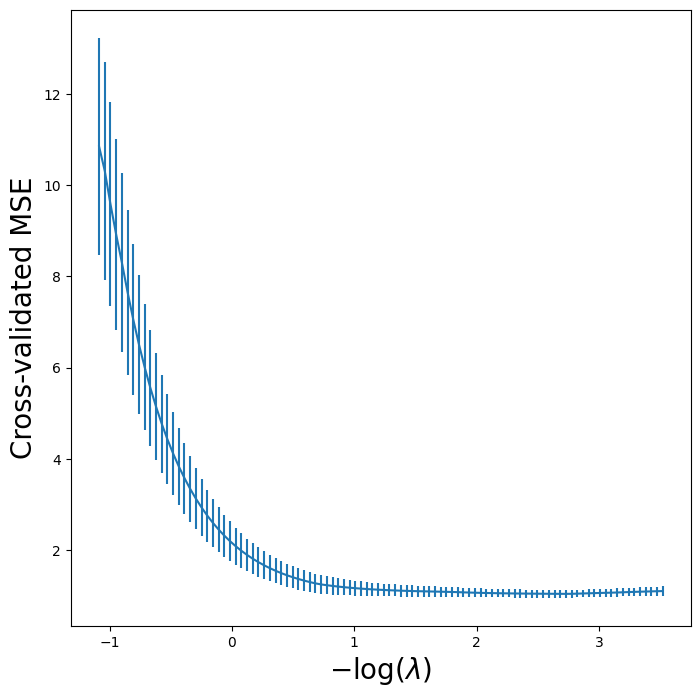

In [12]:
K = 5
kfold = skm.KFold(K,
                 random_state=0,
                 shuffle=True)
grid = skm.GridSearchCV(pipe,
                       param_grid,
                       cv=kfold,
                       scoring='neg_mean_squared_error')
grid.fit(XX,Y)
lasso_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
           -grid.cv_results_['mean_test_score'],
           yerr=grid.cv_results_['std_test_score']/np.sqrt(K))
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)

In [615]:
grid.best_params_['lasso__alpha']

0.06527528312615896

In [616]:
grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', ElasticNet(alpha=0.06527528312615896, l1_ratio=1))])

In [617]:
grid.best_estimator_.named_steps.lasso.coef_

array([ 0.        , -1.89140603,  0.12432337, -1.43116792,  0.        ,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        ])

(f)

Now generate a response vector $Y$ according to the model
$$
Y = \beta_0 + \beta_7 X^7 + \epsilon,
$$
and perform forward stepwise selection and the lasso. Discuss the results obtained.

In [618]:
Y1 = 4 + 8*X**7 + eps
#Lets perform forward stepwise subset selection method for determining the best model
sigma21 = OLS(Y1,XX).fit().scale
newn_Cp = partial(nCp,sigma21)
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))
data_Cp = sklearn_selected(OLS,strategy,
                           scoring=newn_Cp)
data_Cp.fit(XX,Y1)
data_Cp.selected_state_

('X7', 'X9')

It recommends both $X^7$ and $X^9$ as the best predictors 

In [619]:
scaler = StandardScaler(with_mean=True,  with_std=True)
K = 5
kfold = skm.KFold(K,random_state=0,shuffle=True)
lassoCV = skl.ElasticNetCV(n_alphas=100, 
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(XX, Y1)
tuned_lasso = pipeCV.named_steps['lasso']
print('Best lambda',tuned_lasso.alpha_)

Best lambda 0.19286394673039692


In [620]:
tuned_lasso.coef_

array([  0.        ,  -0.66457253,  -0.        ,   0.        ,
        -0.        ,  24.93032253,  -1.10506572, 129.09304727,
        -0.        ,  40.17435181,  -0.        ])

6.9

In this exercise, we will predict the number of applications received using the other variables in the College data set.

In [621]:
college = load_data('College')
college = college.dropna()
college['Private01'] = np.where(college.Private == 'Yes',1,0)
design = MS(college.columns.drop(['Apps','Private'])).fit(college)
y = college['Apps']
X = design.transform(college)

(a)

Split the data set into a training set and a test set.

In [622]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5,random_state=0)

X_train.shape

(388, 18)

(b)

Fit a linear model using least squares on the training set, and report the test error obtained.

In [623]:
model = OLS(y_train,X_train).fit()
model.summary()
mod_pred = model.predict(X_test)
OLS_MSE = np.mean((y_test-mod_pred)**2)
print("The test error for OLS is ",np.mean((y_test-mod_pred)**2))

The test error for OLS is  1260390.8426037629


(c)

Fit a ridge regression model on the training set, with $\lambda$ chosen by cross-validation. Report the test error obtained.

In [624]:
lambdas = 10**np.linspace(10,-10,100)
scaler = StandardScaler(with_mean=True,  with_std=True)
# Create a 5-fold cross-validation for ridge regression
K = 5
kfold = skm.KFold(K,random_state=0,shuffle=True)
ridgeCV = skl.ElasticNetCV(alphas=lambdas, 
                           l1_ratio=0,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])
pipeCV.fit(X_train, y_train)
tuned_ridge = pipeCV.named_steps['ridge']
Ridge_MSE = np.min(tuned_ridge.mse_path_.mean(1))
print("The minimum test MSE: ", np.min(tuned_ridge.mse_path_.mean(1)))

The minimum test MSE:  1363263.4404381183


(d)

Fit a lasso model on the training set, with $\lambda$ chosen by cross-validation. Report the test error obtained, along with the number of non-zero coefficient estimates.

In [625]:
lambdas = 10**np.linspace(10,-10,100)
scaler = StandardScaler(with_mean=True,  with_std=True)
# Create a 5-fold cross-validation for lasso regression
K = 5
kfold = skm.KFold(K,random_state=0,shuffle=True)
lassoCV = skl.ElasticNetCV(alphas=lambdas, 
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X_train, y_train)
tuned_lasso = pipeCV.named_steps['lasso']
lasso_MSE = np.min(tuned_lasso.mse_path_.mean(1))
print("The minimum test MSE: ", np.min(tuned_lasso.mse_path_.mean(1)))

The minimum test MSE:  1344735.5320200277


(e)

 Fit a PCR model on the training set, with $\mathcal{M}$ chosen by cross-validation. Report the test error obtained, along with the value of $\mathcal{M}$ selected by cross-validation.

In [626]:
pca = PCA(n_components=1)
linreg = skl.LinearRegression()
scaler = StandardScaler()
param_grid = {'pca__n_components': range(1,18)}
pipe = Pipeline([('scaler', scaler),
                ('pca', pca),
                ('linreg', linreg)])
grid = skm.GridSearchCV(pipe,
                       param_grid,
                       cv=kfold,
                       scoring='neg_mean_squared_error')
grid.fit(X_train,y_train)
res = grid.best_estimator_.predict(X_test)
grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=17)),
                ('linreg', LinearRegression())])

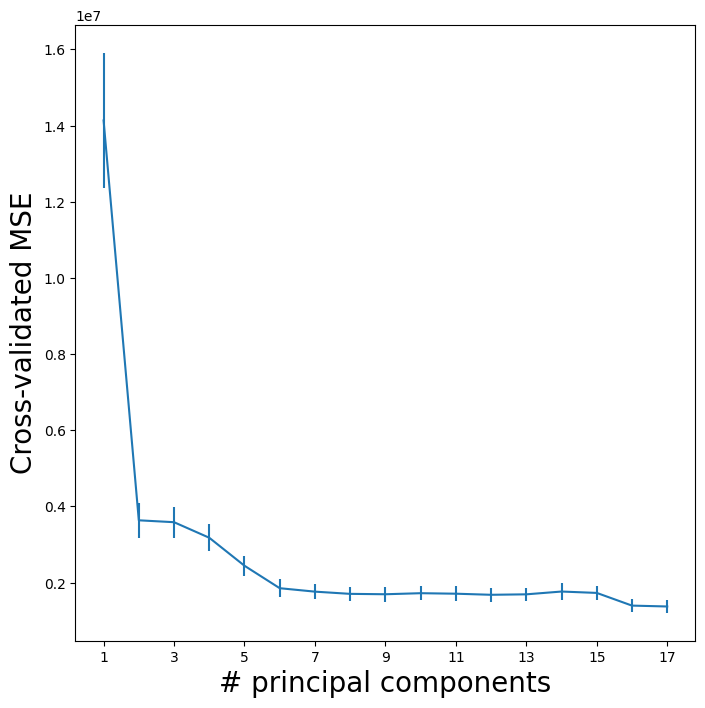

In [627]:
pcr_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp,-grid.cv_results_['mean_test_score'],
grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])

In [628]:
PCR_MSE = np.mean((y_test-res)**2)
print('PCR test error: ', PCR_MSE)

PCR test error:  1260390.8426037806


(f)

Fit a PLS model on the training set, with $\mathcal{M}$ chosen by cross-validation. Report the test error obtained, along with the value of $\mathcal{M}$ selected by cross-validation.

In [629]:
pls = PLSRegression(n_components=1,
                   scale=True)
param_grid = {'n_components': range(1,18)}
grid = skm.GridSearchCV(pls,
                       param_grid,
                       cv=kfold,
                       scoring='neg_mean_squared_error')
grid.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=PLSRegression(n_components=1),
             param_grid={'n_components': range(1, 18)},
             scoring='neg_mean_squared_error')

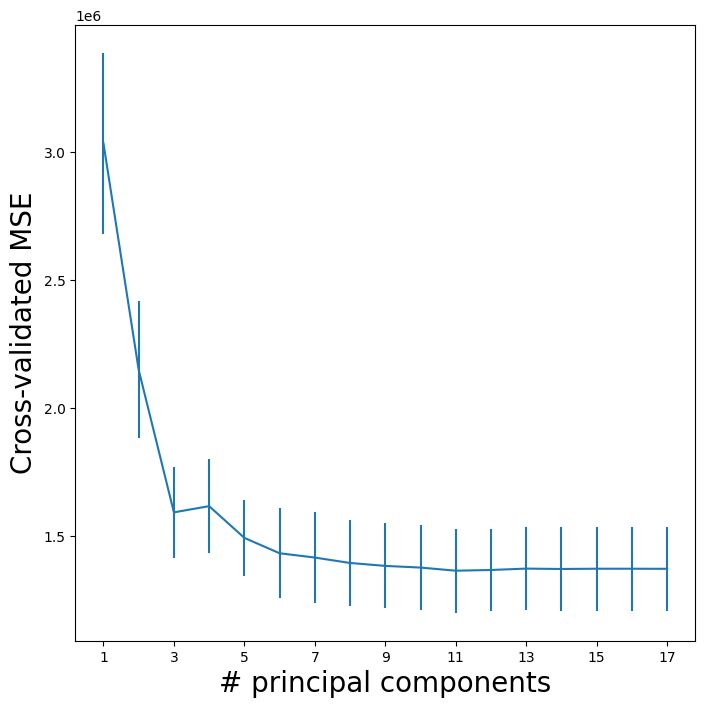

In [630]:
pls_fig,ax = subplots(figsize=(8,8))
n_comp = param_grid['n_components']
ax.errorbar(n_comp,
           -grid.cv_results_['mean_test_score'],
           grid.cv_results_['std_test_score']/np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])

In [631]:
res = grid.best_estimator_.predict(X_test)

PLS_MSE = np.mean((y_test-res)**2)
print('PLS test error: ', PLS_MSE)

PLS test error:  1272224.6706328865


(g)

Comment on the results obtained. How accurately can we predict the number of college applications received? Is there much difference among the test errors resulting from these five approaches?

In [632]:
d = {'OLS': [OLS_MSE], 'Ridge': [Ridge_MSE], 'Lasso': [lasso_MSE], 'PCR': [PCR_MSE], 'PLS': [PLS_MSE]}
df = pd.DataFrame(data=d)
df.T

,0
OLS,1.260391e+06
Ridge,1.363263e+06
Lasso,1.344736e+06
PCR,1.260391e+06
PLS,1.272225e+06


OLS and PCR show the lowest error although PCR goes a bit overboard in using all but one variable, in which case we aren't necessary doing dimensionality reduction. That is we are basically performing OLS with every variable.

6.10

We have seen that as the number of features used in a model increases, the training error will necessarily decrease, but the test error may not. We will now explore this in a simulated data set.

(a)

Generate a data set with $p = 20$ features, $n =1000$ observations, and an associated quantitative response vector generated according to the model
$$
Y = X\beta + \epsilon,
$$
where $\beta$ has some elements that are exactly equal to zero.

In [680]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

rng = np.random.default_rng(42)
p = 20
n = 1000
eps = rng.normal(size=n).reshape(-1,1)
x = rng.normal(size=n).reshape(-1,1)
beta = np.array([4,5,2,10,0,0,20,6,-2.3,0,-4,-20,1,5,0,4,0,2,-1,0,0.76]).reshape(-1,1)

# Create a dataset containing polynomial features
A = make_pipeline(PolynomialFeatures(p))
X = A.fit_transform(x)

Y = np.dot(X,beta) + eps

data = pd.DataFrame(X,columns=['X_' + str(i) for i in range(0,21)])
print(data.shape)
data.head()

(1000, 21)


,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20
0,1.0,-0.059283,0.003514,-2.083448e-04,1.235123e-05,-7.322138e-07,4.340757e-08,-2.573316e-09,1.525530e-10,-9.043743e-12,...,-3.178362e-14,1.884217e-15,-1.117014e-16,6.621953e-18,-3.925669e-19,2.327241e-20,-1.379650e-21,8.178929e-23,-4.848685e-24,2.874429e-25
1,1.0,-0.729287,0.531859,-3.878781e-01,2.828745e-01,-2.062966e-01,1.504495e-01,-1.097208e-01,8.001796e-02,-5.835605e-02,...,-3.103722e-02,2.263504e-02,-1.650744e-02,1.203866e-02,-8.779636e-03,6.402874e-03,-4.669532e-03,3.405429e-03,-2.483535e-03,1.811209e-03
2,1.0,-0.414473,0.171788,-7.120147e-02,2.951109e-02,-1.223155e-02,5.069649e-03,-2.101233e-03,8.709044e-04,-3.609664e-04,...,-6.200967e-05,2.570134e-05,-1.065251e-05,4.415180e-06,-1.829973e-06,7.584746e-07,-3.143673e-07,1.302968e-07,-5.400450e-08,2.238341e-08
3,1.0,0.633910,0.401842,2.547320e-01,1.614773e-01,1.023621e-01,6.488842e-02,4.113344e-02,2.607491e-02,1.652916e-02,...,6.642116e-03,4.210506e-03,2.669084e-03,1.691960e-03,1.072551e-03,6.799012e-04,4.309964e-04,2.732131e-04,1.731926e-04,1.097886e-04
4,1.0,0.002993,0.000009,2.681927e-08,8.027788e-11,2.402951e-13,7.192731e-16,2.152994e-18,6.444537e-21,1.929038e-23,...,1.728378e-28,5.173538e-31,1.548591e-33,4.635382e-36,1.387505e-38,4.153206e-41,1.243176e-43,3.721187e-46,1.113859e-48,3.334106e-51


(b)

Split your data set into a training set containing 100 observations and a test set containing 900 observations.

In [681]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.9,random_state=0)

print("# of observations in training: ",X_train.shape[0])
print("# of observations in test: ", X_test.shape[0])

# of observations in training:  100
# of observations in test:  900


In [684]:
X_train

array([[ 1.00000000e+00,  2.00096310e+00,  4.00385333e+00, ...,
         2.64425566e+05,  5.29105801e+05,  1.05872119e+06],
       [ 1.00000000e+00,  5.42594463e-01,  2.94408752e-01, ...,
         1.66171462e-05,  9.01637153e-06,  4.89223327e-06],
       [ 1.00000000e+00,  1.11950068e+00,  1.25328177e+00, ...,
         7.62848886e+00,  8.54009847e+00,  9.56064605e+00],
       ...,
       [ 1.00000000e+00,  1.07784336e+00,  1.16174630e+00, ...,
         3.85479849e+00,  4.15486894e+00,  4.47829788e+00],
       [ 1.00000000e+00, -1.45810458e-01,  2.12606897e-02, ...,
         8.87556765e-16, -1.29415059e-16,  1.88700690e-17],
       [ 1.00000000e+00, -6.39503391e-01,  4.08964587e-01, ...,
         3.20015732e-04, -2.04651146e-04,  1.30875102e-04]])

(c)

Perform best subset selection on the training set, and plot the training set MSE associated with the best model of each size.

In [682]:
def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    X = sm.add_constant(X)
    model = sm.OLS(Y,X).fit()
    return model.ssr,model.rsquared,model
    

from tqdm import tnrange, tqdm_notebook
from itertools import combinations

def run_subset_selection_with_return_models(X,y):
    #Initialization variables
    RSS_list, R_squared_list, feature_list = [],[],[]
    aic_list,bic_list,adj_r_squared_list = [],[],[]
    numb_features = []
    list_models = []
    list_train_mse = []

    #Looping over k = 1 to k = 11 features in X
    for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):
        best_features = None
        best_RSS = None
        best_r2 = 0
        best_model = None
        
        #Looping over all possible combinations: 
        for combo in combinations(X.columns,k):
            tmp_result = fit_linear_reg(X[list(combo)],y)   #Store temp result  
            r2 = tmp_result[1]
            if r2 > best_r2:
                best_features = combo
                best_RSS = tmp_result[0]
                best_r2 = tmp_result[1]
                best_model = tmp_result[2]
                
        RSS_list.append(best_RSS)
        R_squared_list.append(best_r2)
        feature_list.append(best_features)
        numb_features.append(len(best_features))
        aic_list.append(best_model.aic)
        bic_list.append(best_model.bic)
        adj_r_squared_list.append(best_model.rsquared_adj)
        list_models.append(best_model)
        
    #Store in DataFrame
    df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,
                      'AIC':aic_list,'BIC':bic_list,'adj_r2':adj_r_squared_list,'features':feature_list})
    return df,list_models

In [683]:
results_best_subset,best_subset_models = run_subset_selection_with_return_models(X_train.iloc[:,:12],y_train)
results_best_subset

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

Text(0.5, 0, '# of features')

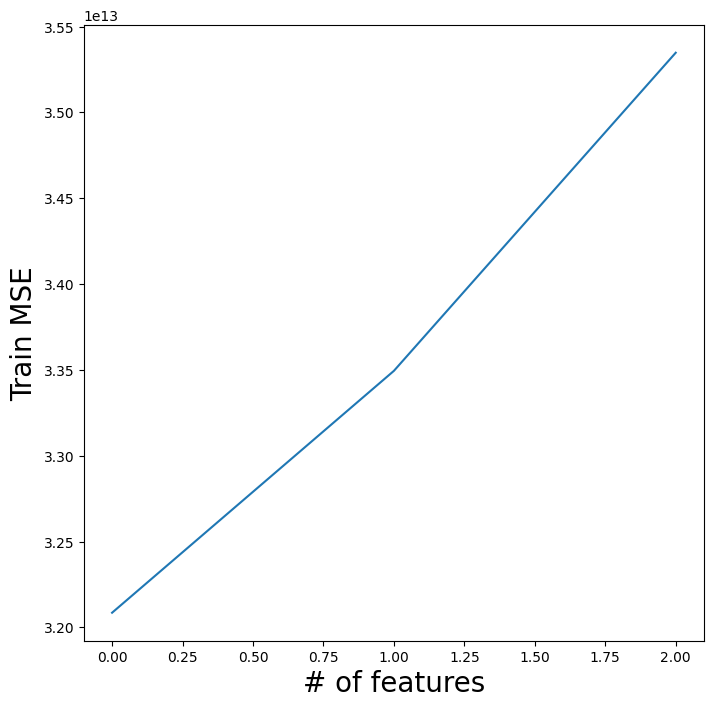

In [672]:
from itertools import chain, combinations
n_features = X.shape[1]
subsets = (combinations(range(n_features), k + 1) 
           for k in range(n_features))
def BSS(estimator, X_train, y_train, X_test, y_test):
    test_MSE = []
    train_MSE = []
    test_sub = []
    n_features = X_train.shape[1]
    subsets = (combinations(range(n_features), k +  1)
              for k in range(3))
    for subset_n in subsets:
        best_MSE = np.inf
        best_msetr = np.inf
        best_subset = None
        for k_subset in subset_n:
            model = OLS(y_train, X_train[:,list(k_subset)]).fit()
            ytr_pred = model.predict(X_train[:,list(k_subset)])
            MSEtr = np.mean((y_train - ytr_pred)**2)
            y_pred = model.predict(X_test[:,list(k_subset)])
            MSE = np.mean((y_test - y_pred)**2)
            if MSE < best_MSE:
                best_MSE = MSE
                best_subset = k_subset
                best_msetr = MSEtr
        test_MSE.append(best_MSE)
        test_sub.append(best_subset)
        train_MSE.append(best_msetr)
    return test_MSE, test_sub, train_MSE

testMSE, sub, trainMSE = BSS(OLS, X_train, y_train, X_test, y_test)
pls_fig,ax = subplots(figsize=(8,8))
n_comp = param_grid['n_components']
ax.plot(range(len(sub)),
       trainMSE)
ax.set_ylabel('Train MSE', fontsize=20)
ax.set_xlabel('# of features', fontsize=20)

(d)

Plot the test set MSE associated with the best model of each size.

(e)

For which model size does the test set MSE take on its minimum value? Comment on your results. If it takes on its minimum value for a model containing only an intercept or a model containing all of the features, then play around with the way that you are generating the data in (a) until you come up with a scenario in which the test set MSE is minimized for an intermediate model size.

(f)

How does the model at which the test set MSE is minimized compare to the true model used to generate the data? Comment on the coefficient values.

(g)

Create a plot displaying $\sqrt{\sum_{j=1}^{p}(\beta_j - \hat{\beta}_j^r)^2}$  for a range of values of $r$, where $\hat{\beta}_j^r$ is the $j$th coefficient estimate for the best model containing $r$ coefficients. Comment on what you observe. How does this compare to the test MSE plot from (d)?

6.11

We will now try to predict per capita crime rate in the Boston data set.

(a)

Try out some of the regression methods explored in this chapter, such as best subset selection, the lasso, ridge regression, and PCR. Present and discuss results for the approaches that you consider.

(b)

Propose a model (or set of models) that seem to perform well on this data set, and justify your answer. Make sure that you are evaluating model performance using validation set error, crossvalidation, or some other reasonable alternative, as opposed to using training error.

(c)

Does your chosen model involve all of the features in the data set? Why or why not?